In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif
import zipfile
import os
from sklearn.feature_selection import mutual_info_classif

In [38]:
url = 'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'
!wget $url -O bank-marketing.zip

--2024-12-21 12:21:13--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-marketing.zip’

bank-marketing.zip      [ <=>                ] 999.85K  --.-KB/s    in 0.1s    

2024-12-21 12:21:13 (9.50 MB/s) - ‘bank-marketing.zip’ saved [1023843]



In [40]:
with zipfile.ZipFile('bank-marketing.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [41]:
if 'bank.zip' in os.listdir():
    with zipfile.ZipFile('bank.zip', 'r') as zip_ref:
        zip_ref.extractall()

In [42]:
df = pd.read_csv('bank-full.csv', sep=';')

Выборка указанных признаков

In [43]:

selected_columns = ['age', 'job', 'marital', 'education', 'balance', 'housing',
                    'contact', 'day', 'month', 'duration', 'campaign',
                    'pdays', 'previous', 'poutcome', 'y']

df = df[selected_columns]


Проверка пропусков

In [44]:

df.isnull().sum()


,0
age,0
job,0
marital,0
education,0
balance,0
housing,0
contact,0
day,0
month,0
duration,0


Вопрос 1: Наиболее частое значение (mode) для столбца education

In [45]:

mode_education = df['education'].mode()[0]
print(mode_education)


secondary


Вопрос 2: Корреляционная матрица для числовых признаков

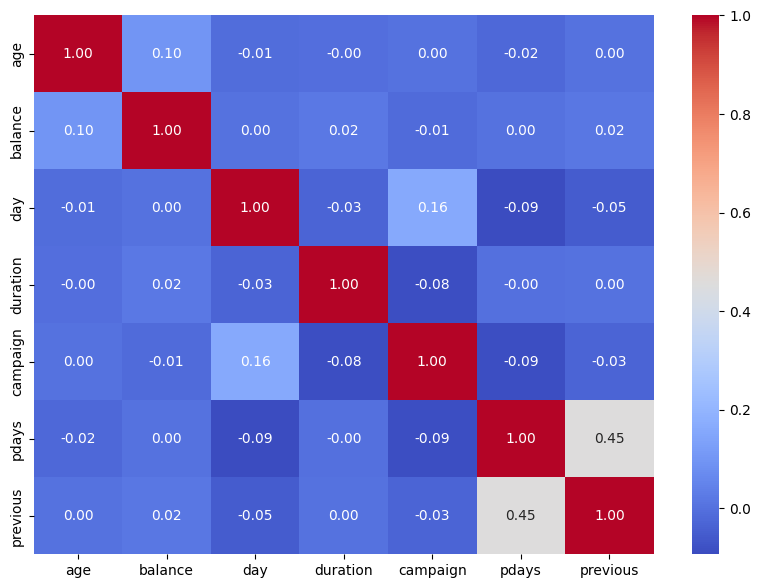

previous  pdays    0.45482
dtype: float64


In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

max_corr = correlation_matrix.unstack().sort_values(ascending=False)
max_corr = max_corr[max_corr != 1].head(1)
print(max_corr)


Вопрос 3

In [47]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split


X = df.drop('y', axis=1)
y = df['y']

X = pd.get_dummies(X)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

mutual_info = mutual_info_classif(X_train, y_train)
mutual_info_series = pd.Series(mutual_info, index=X_train.columns)

mutual_info_series = mutual_info_series.round(2)
print(mutual_info_series)

max_mutual_info_feature = mutual_info_series.idxmax()
print(max_mutual_info_feature)


age                    0.01
balance                0.02
day                    0.01
duration               0.07
campaign               0.00
pdays                  0.03
previous               0.01
job_admin.             0.00
job_blue-collar        0.00
job_entrepreneur       0.00
job_housemaid          0.00
job_management         0.00
job_retired            0.00
job_self-employed      0.00
job_services           0.00
job_student            0.00
job_technician         0.00
job_unemployed         0.00
job_unknown            0.00
marital_divorced       0.00
marital_married        0.01
marital_single         0.00
education_primary      0.00
education_secondary    0.01
education_tertiary     0.00
education_unknown      0.00
housing_no             0.01
housing_yes            0.01
contact_cellular       0.02
contact_telephone      0.00
contact_unknown        0.02
month_apr              0.00
month_aug              0.00
month_dec              0.00
month_feb              0.00
month_jan           

Вопрос 4

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

model.fit(X_train, y_train)

y_pred_valid = model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred_valid)

print(round(accuracy, 2))


0.9


Вопрос 5

In [49]:
from sklearn.metrics import accuracy_score
import numpy as np

def get_accuracy(X_train, y_train, X_valid, y_valid, dropped_feature=None):
    if dropped_feature:
        X_train = X_train.drop(columns=[dropped_feature])
        X_valid = X_valid.drop(columns=[dropped_feature])

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred_valid = model.predict(X_valid)
    return accuracy_score(y_valid, y_pred_valid)

initial_accuracy = get_accuracy(X_train, y_train, X_valid, y_valid)

accuracy_diffs = {}
for feature in X_train.columns:
    accuracy_without_feature = get_accuracy(X_train, y_train, X_valid, y_valid, dropped_feature=feature)
    accuracy_diffs[feature] = initial_accuracy - accuracy_without_feature

min_diff_feature = min(accuracy_diffs, key=accuracy_diffs.get)
print(min_diff_feature, accuracy_diffs[min_diff_feature])


job_entrepreneur -0.0005529138560212976


Вопрос 6

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

C_values = [0.01, 0.1, 1, 10]

accuracy_dict = {}

for C_val in C_values:
    model = LogisticRegression(solver='liblinear', C=C_val, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred_valid = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred_valid)
    accuracy_dict[C_val] = round(accuracy, 3)

print(accuracy_dict)

best_C = max(accuracy_dict, key=accuracy_dict.get)
print("Best C value:", best_C)


{0.01: 0.898, 0.1: 0.899, 1: 0.899, 10: 0.898}
Best C value: 0.1
